In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

2023-05-17 04:25:37.584937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 04:25:37.584976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
training = pd.read_csv("training_data.csv")
test = pd.read_csv("testing_data.csv")

training = training[["Peruntukan","Pusat_kota","Visibilitas","Bangunan","Luas"]]
test = test[["Peruntukan","Pusat_kota","Visibilitas","Bangunan","Luas"]]

# Change categorical to number 

In [3]:
condition = [  training.Pusat_kota == "Pusat",
             training.Pusat_kota == "Sedang",
              training.Pusat_kota == "Pinggir",
]

value = [3,2,1]

training.Pusat_kota = np.select(condition,value)
####
####

condition = [  training.Visibilitas == "Strategis",
             training.Visibilitas == "Sedang",
              training.Visibilitas == "Kurang",
]

value = [3,2,1]

training.Visibilitas = np.select(condition,value)
#####
#####

condition = [  training.Bangunan == "Bagus",
             training.Bangunan == "Sedang",
             
]

value = [2,1]

training.Bangunan = np.select(condition,value,0)


condition = [ 
            training.Peruntukan == "Pasar",
             training.Peruntukan == "Kantor",
             training.Peruntukan == "Ruko",
             training.Peruntukan == "Taman",
             training.Peruntukan == "Perumahan",
             training.Peruntukan == "Sawah",
             
]

value = [5,4,3,2,1,0]

training.Peruntukan = np.select(condition,value,0)

In [4]:
condition = [  test.Pusat_kota == "Pusat",
             test.Pusat_kota == "Sedang",
              test.Pusat_kota == "Pinggir",
]

value = [3,2,1]

test.Pusat_kota = np.select(condition,value)
####
####

condition = [  test.Visibilitas == "Strategis",
             test.Visibilitas == "Sedang",
              test.Visibilitas == "Kurang",
]

value = [3,2,1]

test.Visibilitas = np.select(condition,value)
#####
#####

condition = [  test.Bangunan == "Bagus",
             test.Bangunan == "Sedang",
             
]

value = [2,1]

test.Bangunan = np.select(condition,value,0)


condition = [ 
            test.Peruntukan == "Pasar",
             test.Peruntukan == "Kantor",
             test.Peruntukan == "Ruko",
             test.Peruntukan == "Taman",
             test.Peruntukan == "Perumahan",
             test.Peruntukan == "Sawah",
             
]

value = [5,4,3,2,1,0]

test.Peruntukan = np.select(condition,value,0)

In [5]:
training

,Peruntukan,Pusat_kota,Visibilitas,Bangunan,Luas
0,1,2,3,1,87580
1,1,2,3,1,87580
2,1,2,3,1,87580
3,1,2,3,1,87580
4,1,2,3,1,57945
...,...,...,...,...,...
123,2,3,3,0,1624
124,2,3,3,0,17033
125,2,3,3,0,2074
126,2,3,3,0,1700


In [6]:
test

,Peruntukan,Pusat_kota,Visibilitas,Bangunan,Luas
0,4,3,3,2,1192
1,4,3,2,2,997
2,5,3,3,2,14060
3,5,3,3,1,6025
4,0,1,1,0,10390
5,0,1,1,0,7745
6,0,1,1,0,5700
7,1,2,3,1,27024
8,1,1,2,1,8740
9,3,3,3,2,3614


# Dataframe to Dataset

In [7]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [8]:
train_ds = df_to_dataset(training)
val_ds = df_to_dataset(test)

2023-05-17 04:25:45.694074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 04:25:45.694135: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 04:25:45.694168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gusanwa): /proc/driver/nvidia/version does not exist
2023-05-17 04:25:45.752772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Feature Normalizer

In [9]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [10]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ["Pusat_kota","Visibilitas","Bangunan","Luas"]:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Model build

In [11]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(6)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

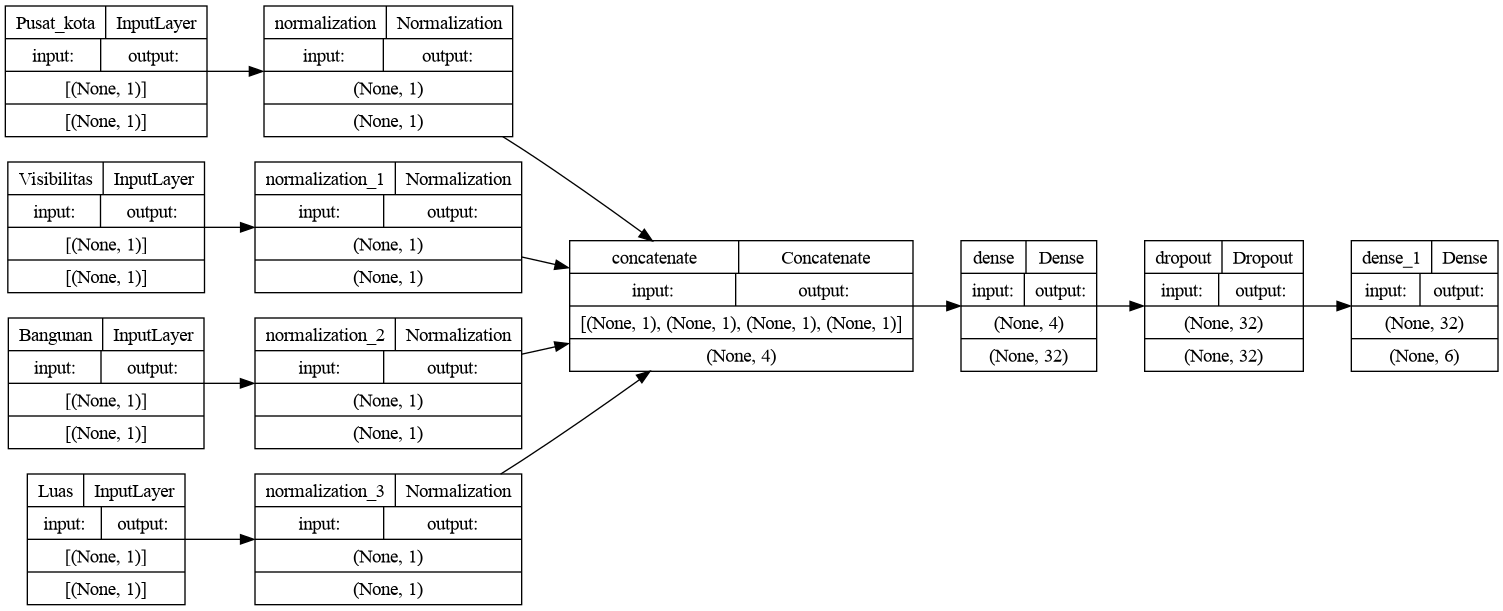

In [12]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [13]:
model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
32/32 [==============================] - 2s 15ms/step - loss: 2.0045 - accuracy: 0.1172 - val_loss: 1.7844 - val_accuracy: 0.1538
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 1.8361 - accuracy: 0.1953 - val_loss: 1.6568 - val_accuracy: 0.4615
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.6891 - accuracy: 0.3047 - val_loss: 1.5526 - val_accuracy: 0.4615
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 1.6430 - accuracy: 0.2969 - val_loss: 1.4630 - val_accuracy: 0.4615
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 1.5646 - accuracy: 0.3984 - val_loss: 1.3880 - val_accuracy: 0.5385
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 1.5082 - accuracy: 0.4062 - val_loss: 1.3176 - val_accuracy: 0.6154
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 1.4185 - accuracy: 0.4844 - val_loss: 1.2574 - val_accuracy: 0.6923
Epoch 8/100


Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5051 - accuracy: 0.8594 - val_loss: 0.3642 - val_accuracy: 0.9231
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.8594 - val_loss: 0.3594 - val_accuracy: 0.9231
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4879 - accuracy: 0.8516 - val_loss: 0.3522 - val_accuracy: 0.9231
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.8672 - val_loss: 0.3512 - val_accuracy: 0.9231
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4573 - accuracy: 0.8828 - val_loss: 0.3460 - val_accuracy: 0.9231
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4470 - accuracy: 0.8906 - val_loss: 0.3419 - val_accuracy: 0.9231
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4162 - accuracy: 0.9062 - val_loss: 0.3381 - val_accuracy: 0.9231
Epoch 

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3046 - accuracy: 0.9141 - val_loss: 0.2496 - val_accuracy: 0.9231
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.9062 - val_loss: 0.2531 - val_accuracy: 0.9231
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8828 - val_loss: 0.2510 - val_accuracy: 0.9231
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8906 - val_loss: 0.2542 - val_accuracy: 0.9231
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3562 - accuracy: 0.9062 - val_loss: 0.2542 - val_accuracy: 0.9231
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3301 - accuracy: 0.9062 - val_loss: 0.2524 - val_accuracy: 0.9231
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.9141 - val_loss: 0.2529 - val_accuracy: 0.9231
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.8906 - val_loss: 0.2103 - val_accuracy: 0.9231
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3105 - accuracy: 0.8984 - val_loss: 0.2069 - val_accuracy: 0.9231
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8750 - val_loss: 0.2053 - val_accuracy: 0.9231
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2795 - accuracy: 0.8906 - val_loss: 0.2096 - val_accuracy: 0.9231
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9375 - val_loss: 0.2090 - val_accuracy: 0.9231
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2698 - accuracy: 0.9062 - val_loss: 0.2092 - val_accuracy: 0.9231
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2375 - accuracy: 0.9062 - val_loss: 0.2070 - val_accuracy: 0.9231
Epoch 

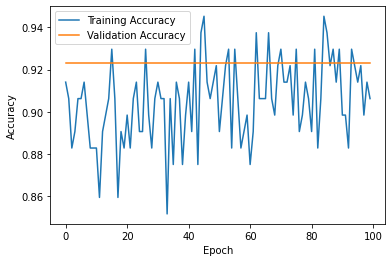

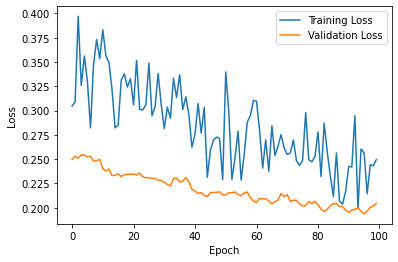

In [14]:
import matplotlib.pyplot as plt

history = model.fit(train_ds, epochs=100, validation_data=val_ds)

# Get the training and validation metrics from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
test

,Peruntukan,Pusat_kota,Visibilitas,Bangunan,Luas
0,4,3,3,2,1192
1,4,3,2,2,997
2,5,3,3,2,14060
3,5,3,3,1,6025
4,0,1,1,0,10390
5,0,1,1,0,7745
6,0,1,1,0,5700
7,1,2,3,1,27024
8,1,1,2,1,8740
9,3,3,3,2,3614


In [16]:
model.predict(val_ds)

array([[-17.36792  ,  -4.636009 , -17.44434  ,   4.0303326,   2.1877816,
         -2.8534906],
       [-13.108229 ,  -3.9224584, -19.196629 ,   0.937001 ,   5.178479 ,
         -7.683483 ],
       [-12.14526  ,  -2.5883715,  -9.43665  ,  -0.8222111,  -0.3843813,
          2.1784651],
       [ -9.732585 ,  -2.0876036,  -2.9050558,  -1.3478363,  -4.2262974,
          1.8460512],
       [  9.635564 ,   3.2383099,  -7.804871 , -17.589327 , -16.28955  ,
        -23.06733  ],
       [  9.579636 ,   3.2238743,  -7.859895 , -16.97309  , -16.01415  ,
        -23.112976 ],
       [  9.512536 ,   3.2283618,  -7.9032984, -16.585428 , -15.835415 ,
        -23.141521 ],
       [ -3.4901443,   3.107796 ,  -2.9284391, -12.144418 ,  -5.9487624,
         -3.2827852],
       [ -1.4672203,   4.47273  , -12.181249 , -14.560785 ,  -5.662055 ,
        -14.876787 ],
       [-16.149359 ,  -4.1692057, -15.984379 ,   3.1128995,   1.9047422,
         -1.9217436],
       [-17.602032 ,  -4.7165046, -17.709034 ,   4

In [17]:
import numpy as np

y_pred = model.predict(val_ds)

         #   test.Peruntukan == "Pasar",
          #   test.Peruntukan == "Kantor",
           #  test.Peruntukan == "Ruko",
            # test.Peruntukan == "Taman",
             #test.Peruntukan == "Perumahan",
             #test.Peruntukan == "Sawah",
            
         #   value = [5,4,3,2,1,0]
y_pred



array([[-17.36792  ,  -4.636009 , -17.44434  ,   4.0303326,   2.1877816,
         -2.8534906],
       [-13.108229 ,  -3.9224584, -19.196629 ,   0.937001 ,   5.178479 ,
         -7.683483 ],
       [-12.14526  ,  -2.5883715,  -9.43665  ,  -0.8222111,  -0.3843813,
          2.1784651],
       [ -9.732585 ,  -2.0876036,  -2.9050558,  -1.3478363,  -4.2262974,
          1.8460512],
       [  9.635564 ,   3.2383099,  -7.804871 , -17.589327 , -16.28955  ,
        -23.06733  ],
       [  9.579636 ,   3.2238743,  -7.859895 , -16.97309  , -16.01415  ,
        -23.112976 ],
       [  9.512536 ,   3.2283618,  -7.9032984, -16.585428 , -15.835415 ,
        -23.141521 ],
       [ -3.4901443,   3.107796 ,  -2.9284391, -12.144418 ,  -5.9487624,
         -3.2827852],
       [ -1.4672203,   4.47273  , -12.181249 , -14.560785 ,  -5.662055 ,
        -14.876787 ],
       [-16.149359 ,  -4.1692057, -15.984379 ,   3.1128995,   1.9047422,
         -1.9217436],
       [-17.602032 ,  -4.7165046, -17.709034 ,   4

In [18]:
val_ds

<BatchDataset element_spec=({'Pusat_kota': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Visibilitas': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Bangunan': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Luas': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
# Ubah output prediksi menjadi label kelas
label_kelas = ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']
y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

# Tampilkan hasil prediksi
print(y_pred_label)

['Ruko', 'Kantor', 'Pasar', 'Pasar', 'Sawah', 'Sawah', 'Sawah', 'Perumahan', 'Perumahan', 'Ruko', 'Ruko', 'Ruko', 'Taman']


In [20]:
for x in y_pred_label:
    print(x)

Ruko
Kantor
Pasar
Pasar
Sawah
Sawah
Sawah
Perumahan
Perumahan
Ruko
Ruko
Ruko
Taman


In [21]:
test

,Peruntukan,Pusat_kota,Visibilitas,Bangunan,Luas
0,4,3,3,2,1192
1,4,3,2,2,997
2,5,3,3,2,14060
3,5,3,3,1,6025
4,0,1,1,0,10390
5,0,1,1,0,7745
6,0,1,1,0,5700
7,1,2,3,1,27024
8,1,1,2,1,8740
9,3,3,3,2,3614


In [22]:
 [ -3.4406643 ,  -0.51060563,  -4.1595945 ,   2.022017  ,
         -0.9544041 ,  -2.0240772 ]

[-3.4406643, -0.51060563, -4.1595945, 2.022017, -0.9544041, -2.0240772]

In [23]:
['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']

['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']